In [90]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-12-19 17:18:48--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  40.0MB/s    in 1.6s    

2019-12-19 17:18:50 (40.0 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile
import cv2 # pip3 install opencv-python
import numpy as np 
from random import shuffle # 隨機資料庫 
from tqdm import tqdm # 輸出進度條
import matplotlib.pyplot as plt # 繪圖

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
img_size = 50
lr = 1e-3

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [94]:
print(train_cats_dir)

/tmp/cats_and_dogs_filtered/train/cats


In [0]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog': return [0,1]

In [0]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(train_cats_dir)):
        if (not img.endswith('.jpg')):
            continue
        label = label_img(img)
        path = os.path.join(train_cats_dir, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # 讀取圖片並轉為灰階
        img = cv2.resize(img, (img_size, img_size) )  # 將圖片轉為統一的大小
        training_data.append([np.array(img), np.array(label)])
    for img in tqdm(os.listdir(train_dogs_dir)):
        if (not img.endswith('.jpg')):
            continue
        label = label_img(img)
        path = os.path.join(train_dogs_dir, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # 讀取圖片並轉為灰階
        img = cv2.resize(img, (img_size, img_size) )  # 將圖片轉為統一的大小
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    return training_data

In [97]:
train_data = create_train_data()

100%|██████████| 1000/1000 [00:01<00:00, 852.54it/s]


In [0]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(validation_cats_dir)):
        if (not img.endswith('.jpg')):
            continue
        path = os.path.join(validation_cats_dir,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        testing_data.append([np.array(img), img_num])
    for img in tqdm(os.listdir(validation_dogs_dir)):
        if (not img.endswith('.jpg')):
            continue
        path = os.path.join(validation_dogs_dir,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        testing_data.append([np.array(img), img_num])   
    shuffle(testing_data)
    return testing_data

In [99]:
!pip install tflearn
import tflearn # 需要安装tensorflow，並安裝 tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d  # 2維 CNN 以及最大池化
from tflearn.layers.core import input_data, dropout, fully_connected # 输入層，dropout，全連接層
from tflearn.layers.estimator import regression # cross entropy層

In [0]:
import tensorflow as tf
tf.reset_default_graph()

In [0]:
convnet = input_data(shape = [None, img_size, img_size, 1], name = 'input')

convnet = conv_2d(convnet, 64, 5, activation='linear') # the number of convolutional filters, filter_size
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='linear')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 16, 5, activation='linear')
convnet = max_pool_2d(convnet, 5)

In [0]:
convnet = fully_connected(convnet, 16, activation = 'linear')
convnet = dropout(convnet, 0.5)

convnet = fully_connected(convnet, 8, activation = 'linear')

convnet = fully_connected(convnet, 4, activation = 'relu')

convnet = fully_connected(convnet, 2, activation='sigmoid')
convnet = regression(convnet, optimizer='adam', learning_rate = lr, loss='categorical_crossentropy', name='targets')

In [0]:
model = tflearn.DNN(convnet, tensorboard_dir='log')

In [0]:
trainNum = int(len(train_data)*-0.1)
train = train_data[:trainNum]
test = train_data[trainNum:]

In [0]:
X = np.array([i[0] for i in train], dtype=np.float64).reshape(-1, img_size, img_size, 1)
y = np.array([i[1] for i in train], dtype=np.float64)
Xtest = np.array([i[0] for i in test], dtype=np.float64).reshape(-1, img_size, img_size, 1)
ytest = np.array([i[1] for i in test], dtype=np.float64)

In [106]:
model.fit({'input': X}, {'targets': y}, n_epoch=10, batch_size=100, validation_set=({'input': Xtest}, {'targets': ytest}), snapshot_step=50, show_metric=True, run_id='model' )

Training Step: 179  | total loss: 0.51402 | time: 5.005s
| Adam | epoch: 010 | loss: 0.51402 - acc: 0.7555 -- iter: 1700/1800
Training Step: 180  | total loss: 0.51120 | time: 6.305s
| Adam | epoch: 010 | loss: 0.51120 - acc: 0.7570 | val_loss: 0.62639 - val_acc: 0.6900 -- iter: 1800/1800
--


In [107]:
test_data = process_test_data()

100%|██████████| 500/500 [00:00<00:00, 818.71it/s]


[0.65780336 0.39765882]
[0.5453937 0.4668211]
[0.9799234  0.08694847]
[0.9887356  0.06280427]
[0.79956824 0.29894155]
[0.9612071 0.1250012]
[0.4058582  0.62162507]
[0.621986   0.42022324]
[0.31572065 0.73451394]
[0.9533443  0.13820133]
[0.0959804 0.9515073]
[0.9111408  0.19501664]
[0.06154415 0.97386575]
[0.30999202 0.7416087 ]
[0.99573106 0.03597962]
[0.94404763 0.15240368]


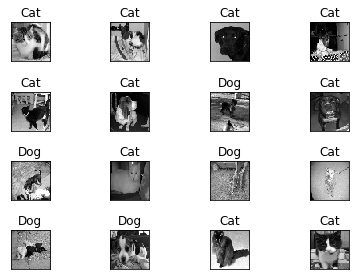

In [108]:
fig = plt.figure()
for num,data in enumerate(test_data[:16]):
    img_num = data[1]
    img_data = data[0]
    y = fig.add_subplot(4, 4, num+1)
    orig = img_data
    data = img_data.reshape(img_size, img_size, 1)
    model_out = model.predict([data])[0]
    print(model_out)
    if np.argmax(model_out) == 1: 
        label = 'Dog'
    else: 
        label = 'Cat'
    
    y.imshow(orig, cmap='gray')
    plt.title(label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.tight_layout()
plt.show()